This is the implementation notebook for [this article](https://towardsdatascience.com/data-whispering-eebb77a422da)

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

# Get the data from Yahoo Finance
ticker = 'AAPL'
start_date = '2000-01-01'
end_date = '2010-12-31'
df = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [2]:
d1 = pd.DataFrame(df['Adj Close'])#create a df with only stock price
d1.rename(columns={'Adj Close':'adj_close'}, inplace=True)
d1['simple_rtn']=d1.adj_close.pct_change()#percentage return
d1['log_rtn'] = np.log(d1.adj_close/d1.adj_close.shift(1))
#log return with 1 day lag
d1.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-03,0.847207,NaN,NaN
2000-01-04,0.775779,-0.084310,-0.088077
2000-01-05,0.787131,0.014633,0.014527
2000-01-06,0.719014,-0.086539,-0.090514
2000-01-07,0.753073,0.047369,0.046281


In [3]:
# drop na and show tail
d1 = d1.dropna()
d1.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-04,0.775779,-0.084310,-0.088077
2000-01-05,0.787131,0.014633,0.014527
2000-01-06,0.719014,-0.086539,-0.090514
2000-01-07,0.753073,0.047369,0.046281
2000-01-10,0.739828,-0.017588,-0.017745


In [4]:
#get mean and std
mu = d1.describe().loc['mean', 'log_rtn']
sigma = d1.describe().loc['std', 'log_rtn']
condition = (d1['log_rtn'] > mu + sigma * 2) | (d1['log_rtn'] < mu - sigma * 2) #set the condition to be 2 times of std around mean
d1['outliers'] = np.where(condition, 1, 0)#like an if, else
d1.head()

,adj_close,simple_rtn,log_rtn,outliers
Date,,,,
2000-01-04,0.775779,-0.084310,-0.088077,1
2000-01-05,0.787131,0.014633,0.014527,0
2000-01-06,0.719014,-0.086539,-0.090514,1
2000-01-07,0.753073,0.047369,0.046281,0
2000-01-10,0.739828,-0.017588,-0.017745,0


In [5]:
#using pd's bool selection to remove outliers
d1_removed_outliers = d1.loc[d1['outliers'] == 0].iloc[:, :-1]
d1_removed_outliers.head(10)

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-05,0.787131,0.014633,0.014527
2000-01-07,0.753073,0.047369,0.046281
2000-01-10,0.739828,-0.017588,-0.017745
2000-01-11,0.701985,-0.051151,-0.052505
2000-01-12,0.659885,-0.059973,-0.061847
2000-01-14,0.760168,0.038114,0.037405
2000-01-18,0.786658,0.034847,0.034254
2000-01-19,0.806526,0.025256,0.024943
2000-01-20,0.859033,0.065103,0.063071


In [6]:
d1_removed_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2668 entries, 2000-01-05 to 2010-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   adj_close   2668 non-null   float64
 1   simple_rtn  2668 non-null   float64
 2   log_rtn     2668 non-null   float64
dtypes: float64(3)
memory usage: 83.4 KB


In [7]:
d1 = d1_removed_outliers

In [8]:
#calculate the pearson correlation
corr = d1[['simple_rtn', 'log_rtn']].corr()
corr

,simple_rtn,log_rtn
simple_rtn,1.000000,0.999853
log_rtn,0.999853,1.000000


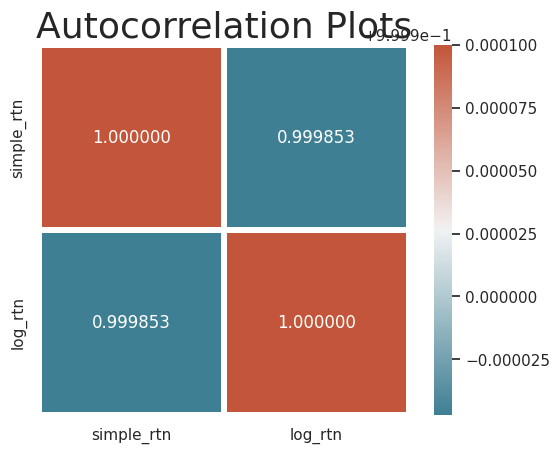

In [9]:
#draw heatmap with seaborne
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w', fmt='.6f')
ax.set_title('Autocorrelation Plots', fontsize=26)
sns.set(font_scale=2);

In [10]:
d1.describe().round(4)

,adj_close,simple_rtn,log_rtn
count,2668.0000,2668.0000,2668.0000
mean,2.4175,0.0015,0.0012
std,2.4648,0.0242,0.0242
min,0.1986,-0.0619,-0.0639
25%,0.3483,-0.0135,-0.0136
50%,1.3422,0.0010,0.0010
75%,3.9384,0.0164,0.0162
max,9.8534,0.0678,0.0656


In [11]:
import scipy.stats as scs
#extract all the stats from describe() function
def extract_data_stats(col):
    d_stat = col.describe()
    mu = d_stat['mean']
    sigma = d_stat['std']
    rtn_range = np.linspace(d_stat['min'], d_stat['max'], num=1000)
    norm_pdf = scs.norm.pdf(rtn_range, loc=mu, scale=sigma)

    return mu, sigma, rtn_range, norm_pdf

In [12]:
#draw the histogram with Probability Density Function
def draw_hist(col, xlim=(-0.2, 0.2)):
    plt.figure(figsize=(10, 8))
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(col)
    sns.distplot(col, kde=True, norm_hist=True, label='Hist')
    plt.plot(rtn_range, norm_pdf, 'r', lw=3,
             label=f'N({mu:.3f}, {sigma**2:.4f})')
    plt.axvline(x=0, c='c',linestyle='--', lw=3)
    plt.title(f'Distribution of {col.name}', fontsize=24)
    plt.xlim(xlim)
    plt.legend(loc='upper right', fontsize=16,
               frameon=True,fancybox=True,
               framealpha=1, shadow=True, borderpad=1);

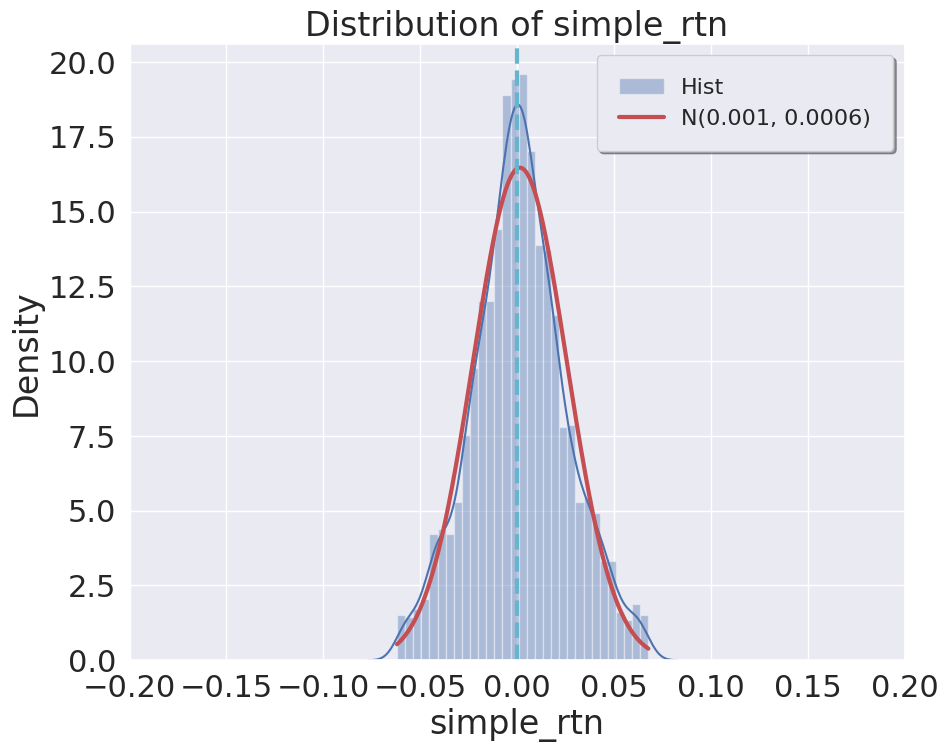

In [13]:
draw_hist(d1.simple_rtn)

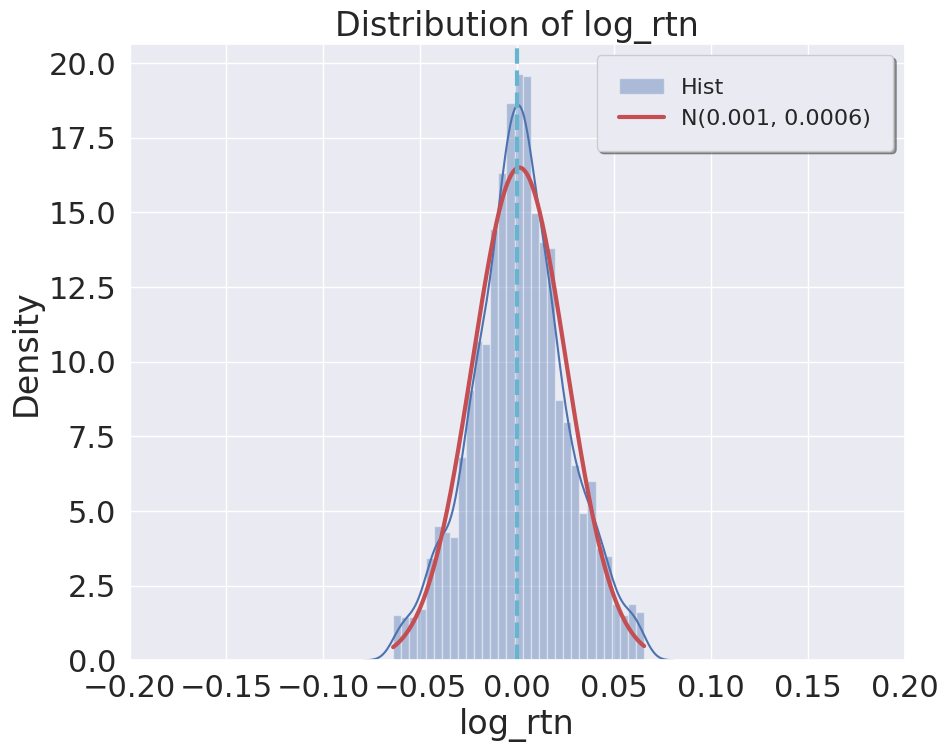

In [14]:
draw_hist(d1.log_rtn)

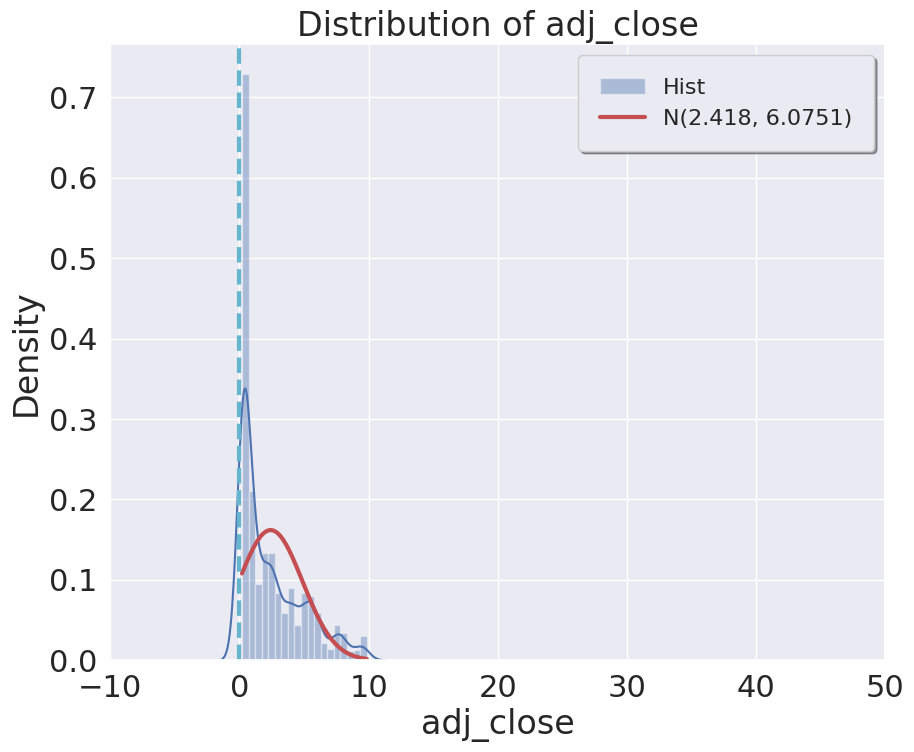

In [15]:
draw_hist(d1.adj_close,xlim=(-10,50))

In [16]:
#get 5 days lagged return by a for loop
df_simple_rtn = pd.DataFrame(d1['adj_close'])
lags = 10
for lag in range(1, lags+1, 2):
    col = f'lag_{lag}_simple_rtn'
    df_simple_rtn[col] = df_simple_rtn['adj_close'].pct_change(periods=lag)

df_simple_rtn.dropna(inplace=True)
df_simple_rtn.head()

,adj_close,lag_1_simple_rtn,lag_3_simple_rtn,lag_5_simple_rtn,lag_7_simple_rtn,lag_9_simple_rtn
Date,,,,,,
2000-01-21,0.842476,-0.019273,0.070957,0.276703,0.138747,0.070313
2000-01-24,0.804161,-0.045480,-0.002932,0.057872,0.145553,0.067839
2000-01-25,0.849572,0.056470,-0.011014,0.079976,0.287455,0.148338
2000-01-26,0.833962,-0.018374,-0.010107,0.034018,0.097076,0.188005
2000-01-27,0.832543,-0.001702,0.035294,-0.030837,0.058329,0.261649


In [17]:
#get 5 days lagged return by a for loop
df_log_rtn = pd.DataFrame(d1['adj_close'])
lags = 10
for lag in range(1, lags+1, 2):
    col = f'lag_{lag}_log_rtn'
    df_log_rtn[col] = np.log(df_log_rtn['adj_close']/\
    df_log_rtn['adj_close'].shift(lag))


df_log_rtn.dropna(inplace=True)
df_log_rtn.describe()

,adj_close,lag_1_log_rtn,lag_3_log_rtn,lag_5_log_rtn,lag_7_log_rtn,lag_9_log_rtn
count,2659.000000,2659.000000,2659.000000,2659.000000,2659.000000,2659.000000
mean,2.423151,0.000915,0.002807,0.004784,0.006750,0.008658
std,2.467053,0.032412,0.055563,0.073791,0.088934,0.101513
min,0.198600,-0.702127,-0.791264,-0.949337,-1.032028,-1.134839
25%,0.348154,-0.014477,-0.022999,-0.029823,-0.032871,-0.036363
50%,1.364310,0.000872,0.003763,0.008796,0.012757,0.015839
75%,3.963659,0.016323,0.032088,0.043324,0.057192,0.065408
max,9.853370,0.204939,0.236206,0.256562,0.298856,0.329493


In [18]:
#using ax to draw multi-grahps
def draw_hist_multi(col, xlim=(-0.2, 0.2), ax=None):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(col)
    sns.distplot(col, kde=True, norm_hist=True, \
                 label='Hist', ax=ax)
    ax.plot(rtn_range, norm_pdf, 'r', lw=3, \
            label=f'N({mu:.3f}, {sigma**2:.4f})')
    ax.axvline(x=0, c='c',linestyle='--', lw=3)
  #adj_close x axis range is wider
    if ( col.name == 'adj_close'):
        ax.set_xlim(-10,50)
    else:
        ax.set_xlim(xlim)
    ax.legend(loc='upper right', fontsize=8,
              frameon=True,fancybox=True);

In [19]:
#create subplots figure with each plot drawed by draw_hist_multi()
def draw_hist_subplots(df):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(32,18))
    fig.subplots_adjust(hspace = .5) #wspace=.001
    fig.suptitle('Distribution of returns with increased time scale', fontsize=50)

    axs = axs.ravel()
    for i, col in enumerate(df.columns):
        draw_hist_multi(df[col], ax=axs[i])

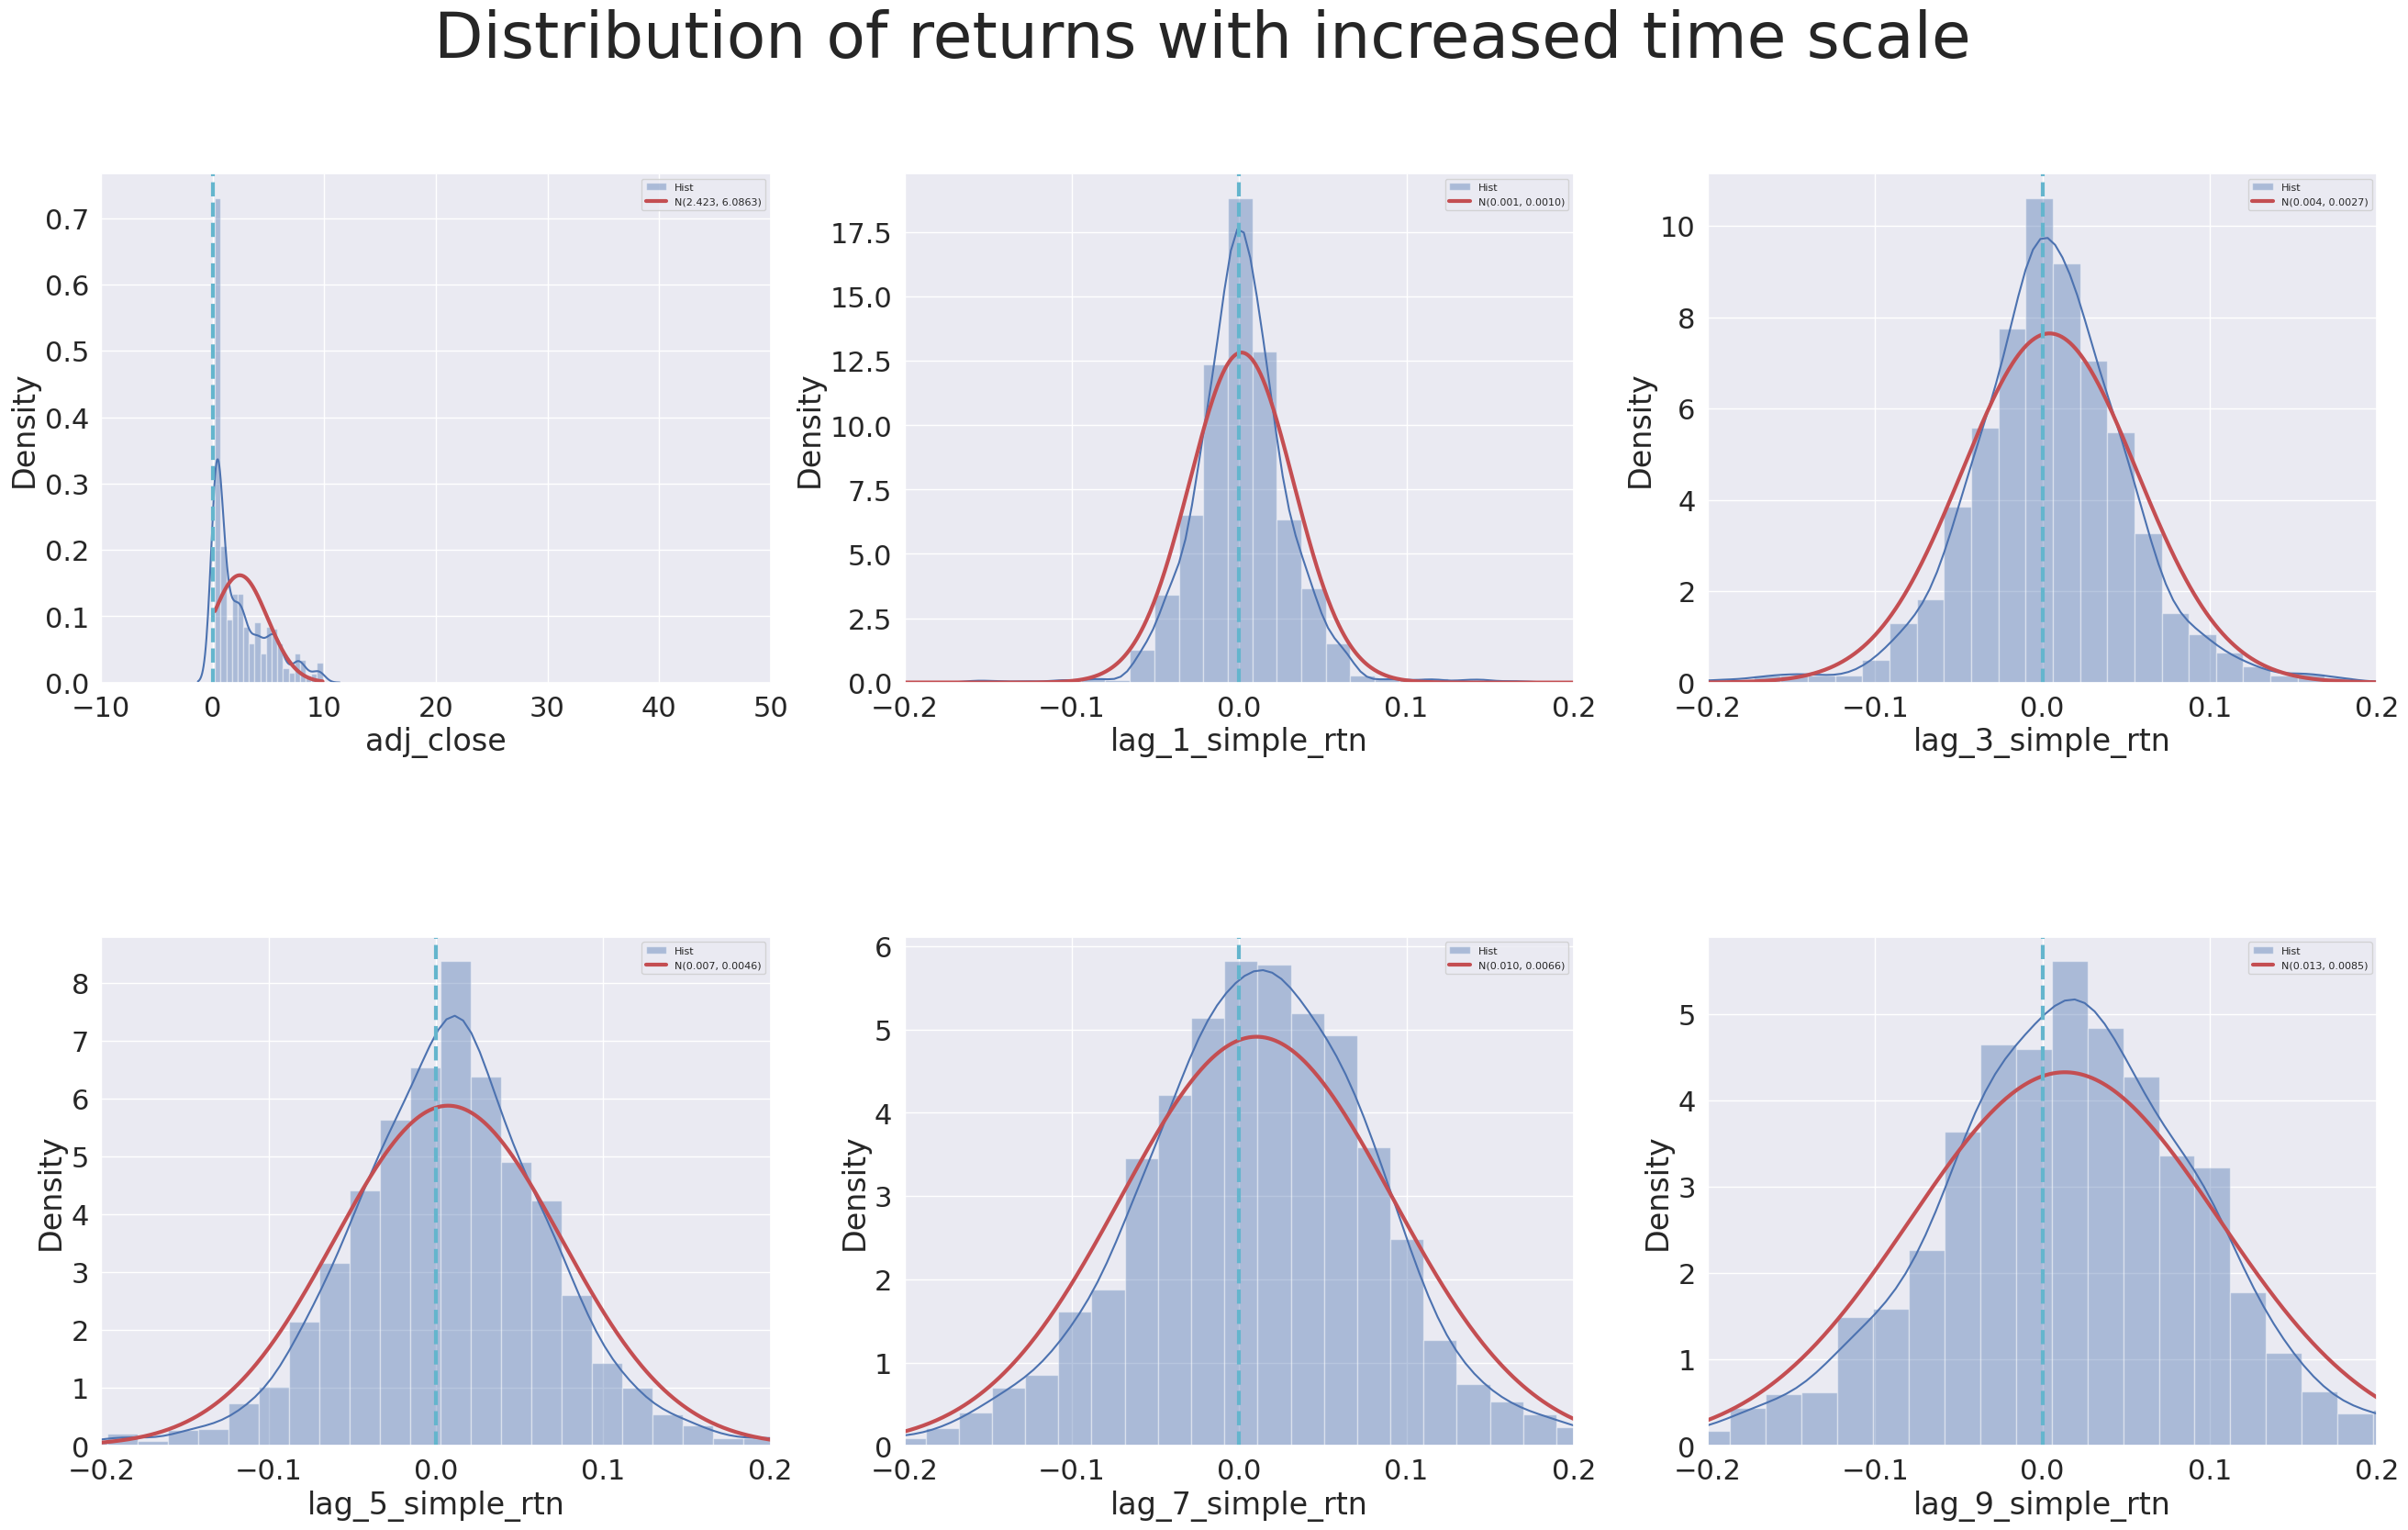

In [20]:
draw_hist_subplots(df_simple_rtn)

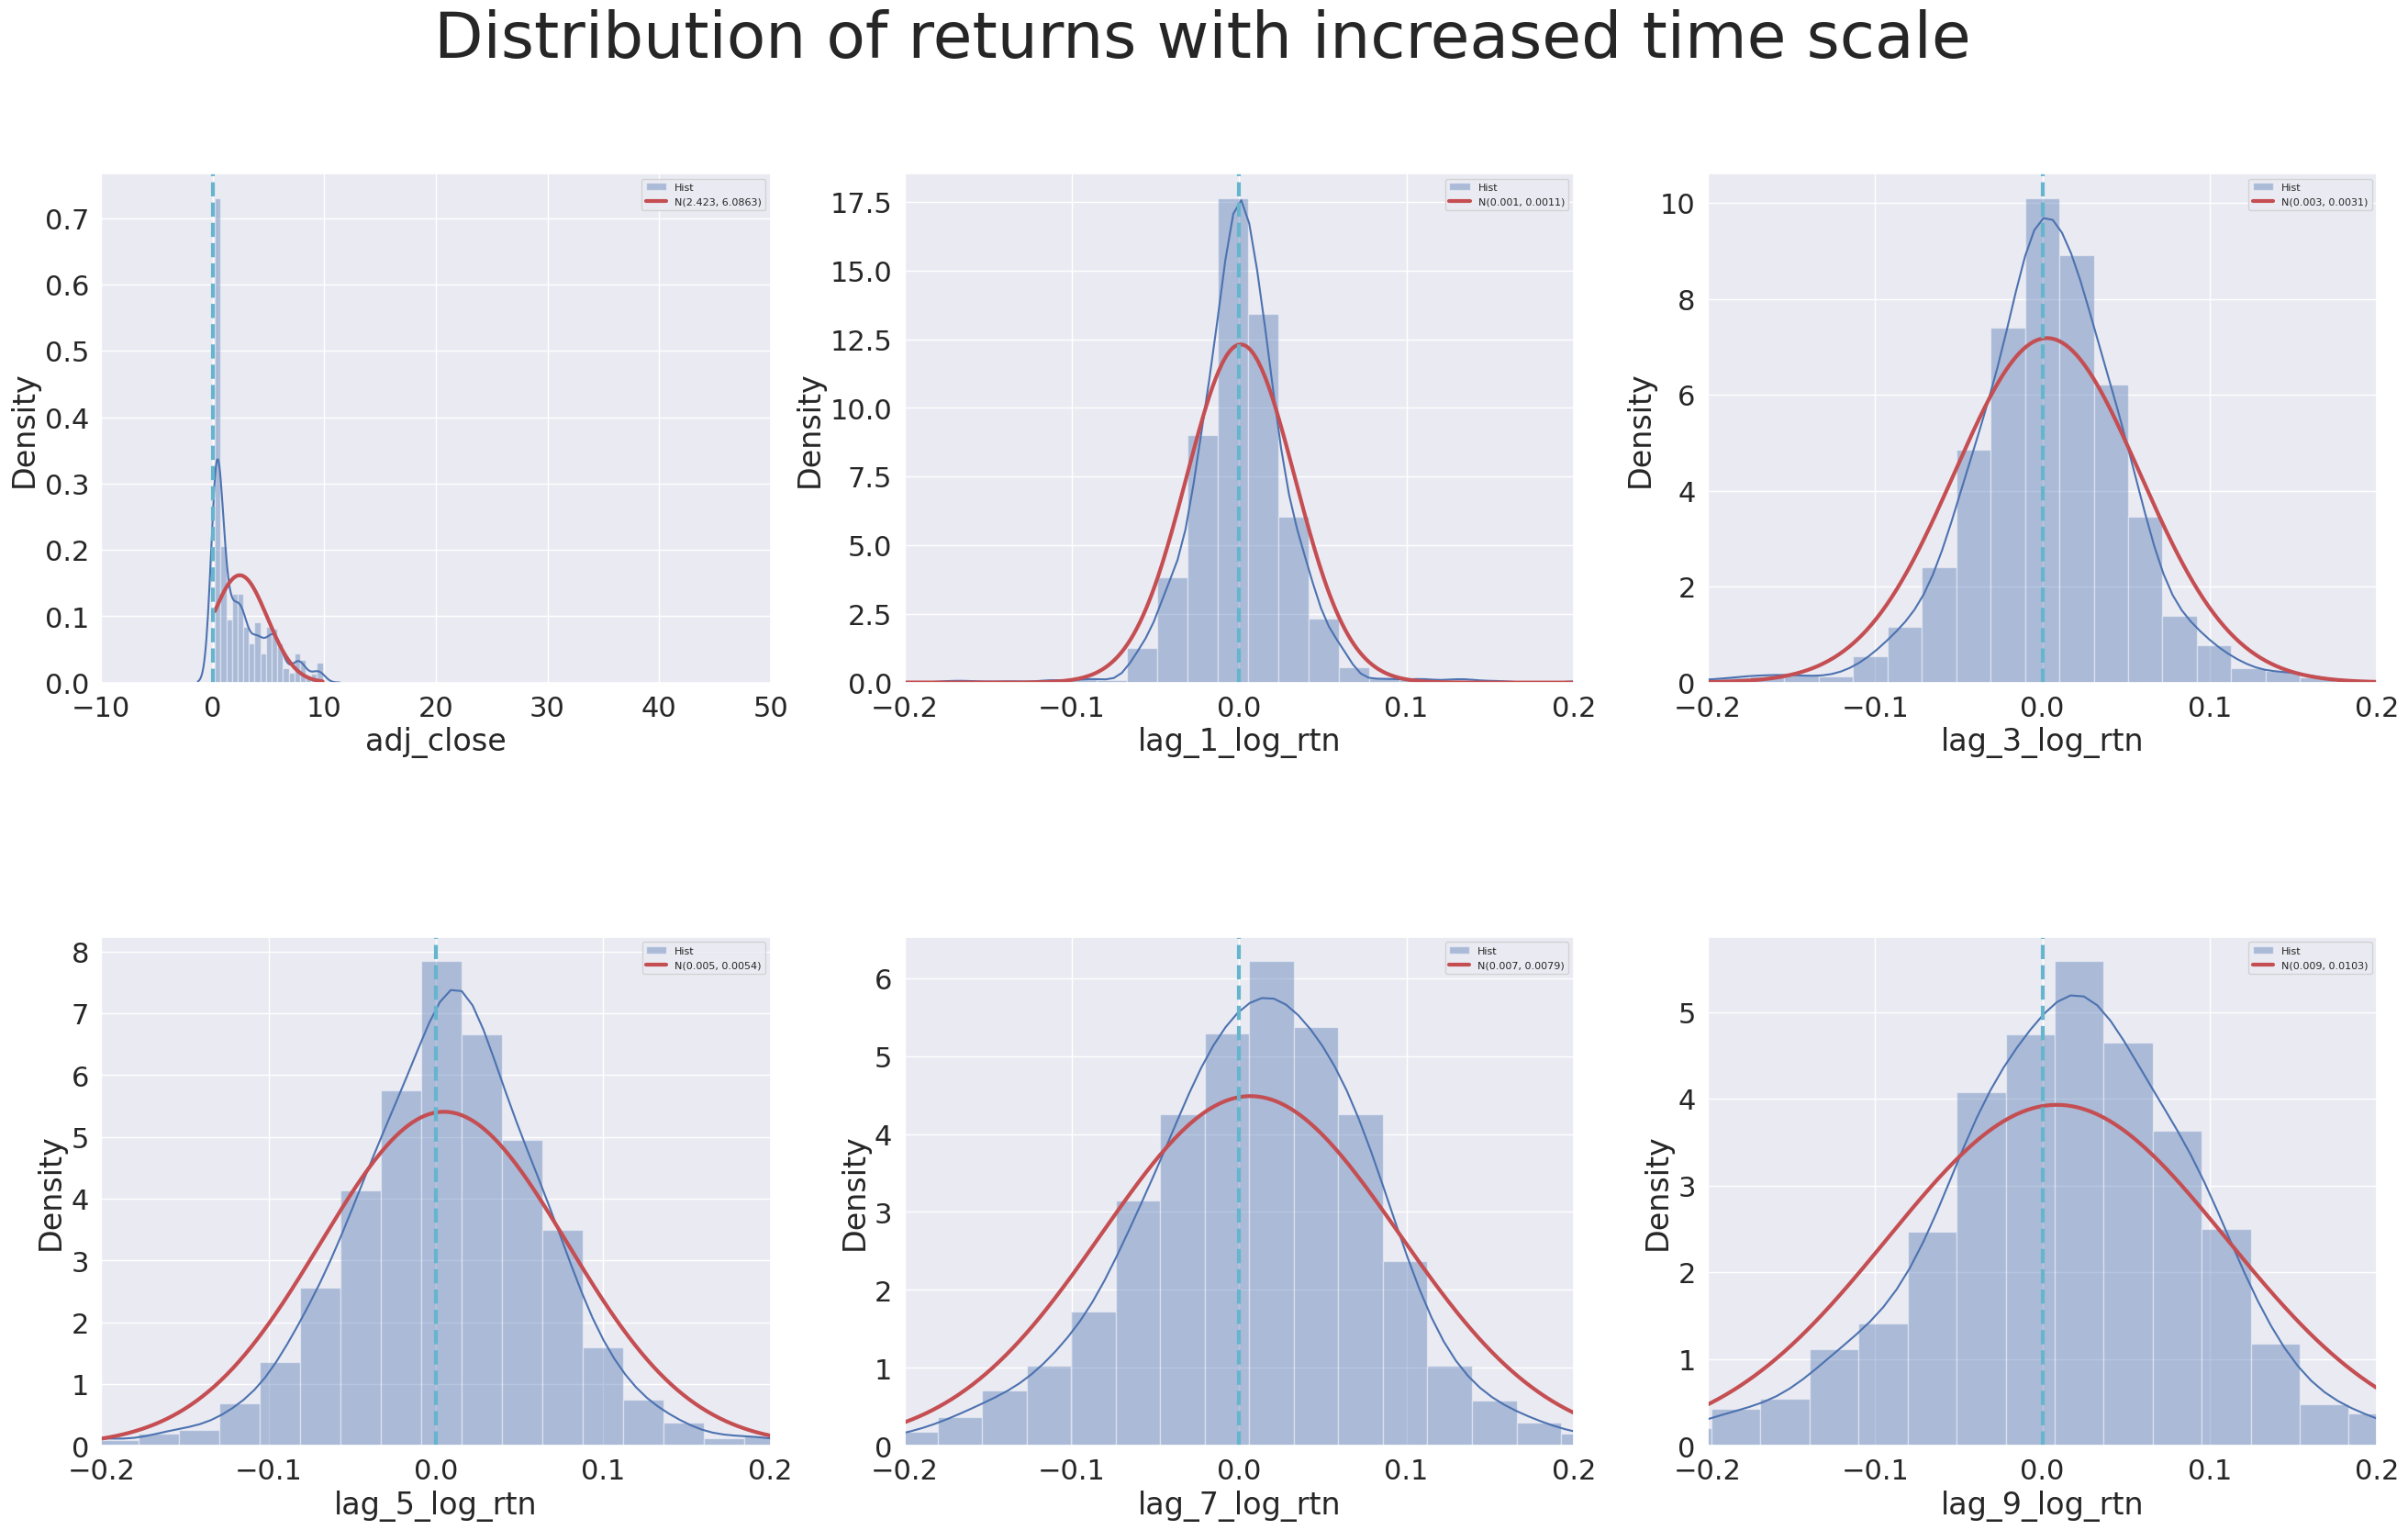

In [21]:
draw_hist_subplots(df_log_rtn)

In [22]:
#using DataFrame to contain all the stats
def build_stats(df):
    stats = pd.DataFrame({'skew':scs.skew(df),
                 'skew_test':scs.skewtest(df)[1],
                 'kurtosis': scs.kurtosis(df),
                 'kurtosis_test' : scs.kurtosistest(df)[1],
                 'normal_test' : scs.normaltest(df)[1]},
                  index = df.columns)
    return stats

In [23]:
build_stats(df_simple_rtn)

,skew,skew_test,kurtosis,kurtosis_test,normal_test
adj_close,1.118551,2.759426e-83,0.316055,3.002236e-03,8.206177e-84
lag_1_simple_rtn,-1.232389,2.835983e-95,31.517858,7.508415e-173,1.948439e-264
lag_3_simple_rtn,-1.252708,2.045339e-97,15.315444,2.446287e-130,4.014692e-224
lag_5_simple_rtn,-1.201203,5.495573e-92,11.904349,2.440587e-115,9.825345e-204
lag_7_simple_rtn,-1.088802,3.661796e-80,8.995943,5.976604e-99,1.383033e-175
lag_9_simple_rtn,-1.024331,2.010125e-73,7.297580,4.312961e-87,4.909930e-157


In [24]:
build_stats(df_log_rtn)

,skew,skew_test,kurtosis,kurtosis_test,normal_test
adj_close,1.118551,2.759426e-83,0.316055,3.002236e-03,8.206177e-84
lag_1_log_rtn,-3.789618,0.000000e+00,87.021797,6.914273e-227,0.000000e+00
lag_3_log_rtn,-3.422338,3.025200e-299,46.737770,7.211427e-195,0.000000e+00
lag_5_log_rtn,-3.533113,6.225894e-308,40.835616,1.856556e-187,0.000000e+00
lag_7_log_rtn,-3.305045,6.764438e-290,33.013942,1.680997e-175,0.000000e+00
lag_9_log_rtn,-3.126960,2.161720e-275,27.779463,1.437781e-165,0.000000e+00


In [25]:
corr_s = df_simple_rtn.corr()
corr_s

,adj_close,lag_1_simple_rtn,lag_3_simple_rtn,lag_5_simple_rtn,lag_7_simple_rtn,lag_9_simple_rtn
adj_close,1.000000,0.018684,0.034129,0.042984,0.049854,0.056915
lag_1_simple_rtn,0.018684,1.000000,0.572982,0.464720,0.394102,0.341631
lag_3_simple_rtn,0.034129,0.572982,1.000000,0.778904,0.676877,0.590203
lag_5_simple_rtn,0.042984,0.464720,0.778904,1.000000,0.852240,0.760140
lag_7_simple_rtn,0.049854,0.394102,0.676877,0.852240,1.000000,0.886184
lag_9_simple_rtn,0.056915,0.341631,0.590203,0.760140,0.886184,1.000000


In [26]:
corr_l = df_log_rtn.corr()
corr_l

,adj_close,lag_1_log_rtn,lag_3_log_rtn,lag_5_log_rtn,lag_7_log_rtn,lag_9_log_rtn
adj_close,1.000000,0.023915,0.041620,0.052240,0.060974,0.069135
lag_1_log_rtn,0.023915,1.000000,0.580075,0.472305,0.395813,0.345452
lag_3_log_rtn,0.041620,0.580075,1.000000,0.789173,0.683198,0.595070
lag_5_log_rtn,0.052240,0.472305,0.789173,1.000000,0.859877,0.767166
lag_7_log_rtn,0.060974,0.395813,0.683198,0.859877,1.000000,0.894017
lag_9_log_rtn,0.069135,0.345452,0.595070,0.767166,0.894017,1.000000


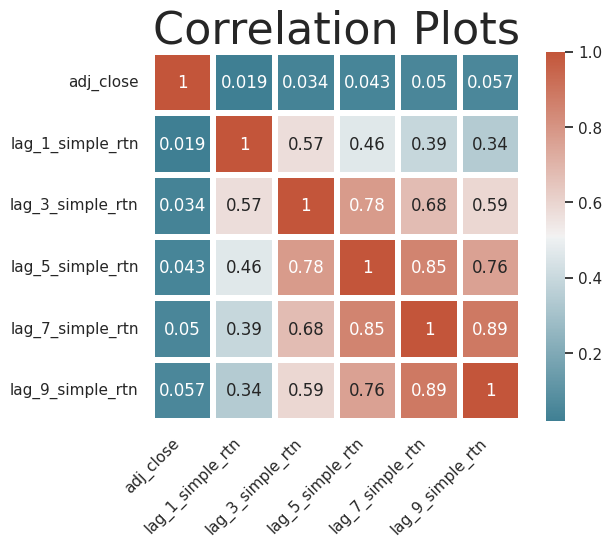

In [27]:
#using seaborne to draw heatmap
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr_s, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w')
ax.set_title('Correlation Plots', fontsize=32)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

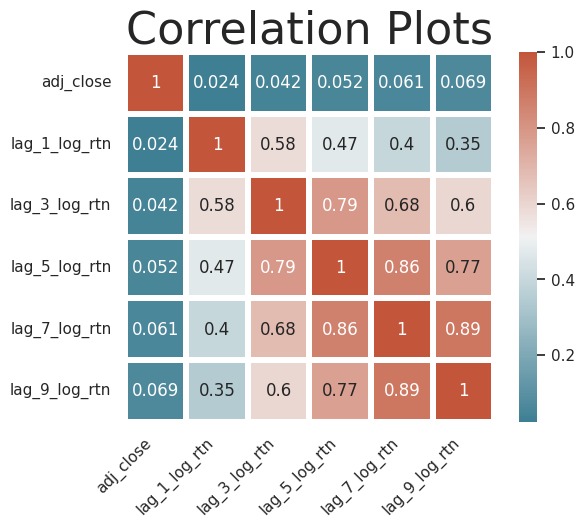

In [28]:
#using seaborne to draw heatmap
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr_l, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w')
ax.set_title('Correlation Plots', fontsize=32)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

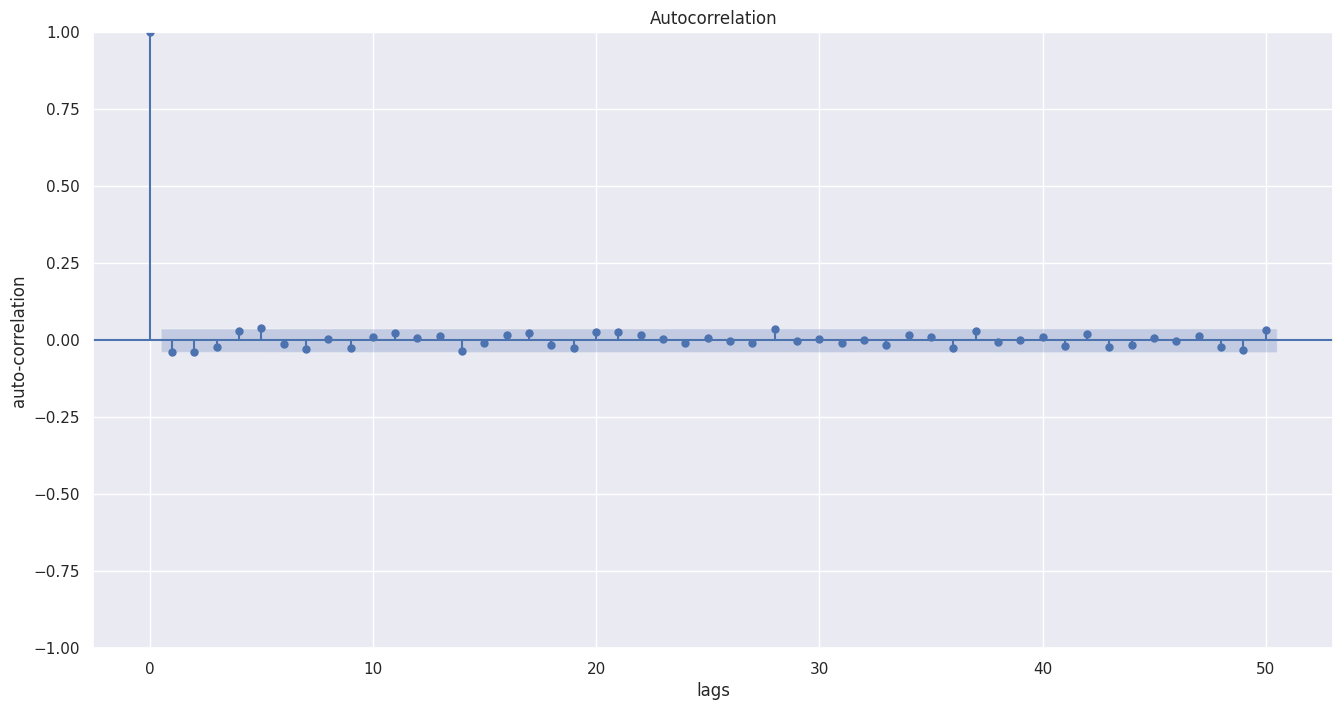

In [32]:
#draw autocorrelation for log return with 50 days time lag
sns.set()
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(16, 8))
acf = plot_acf(d1.simple_rtn, lags=50, ax=ax)
ax.set_xlabel('lags')
ax.set_ylabel('auto-correlation');

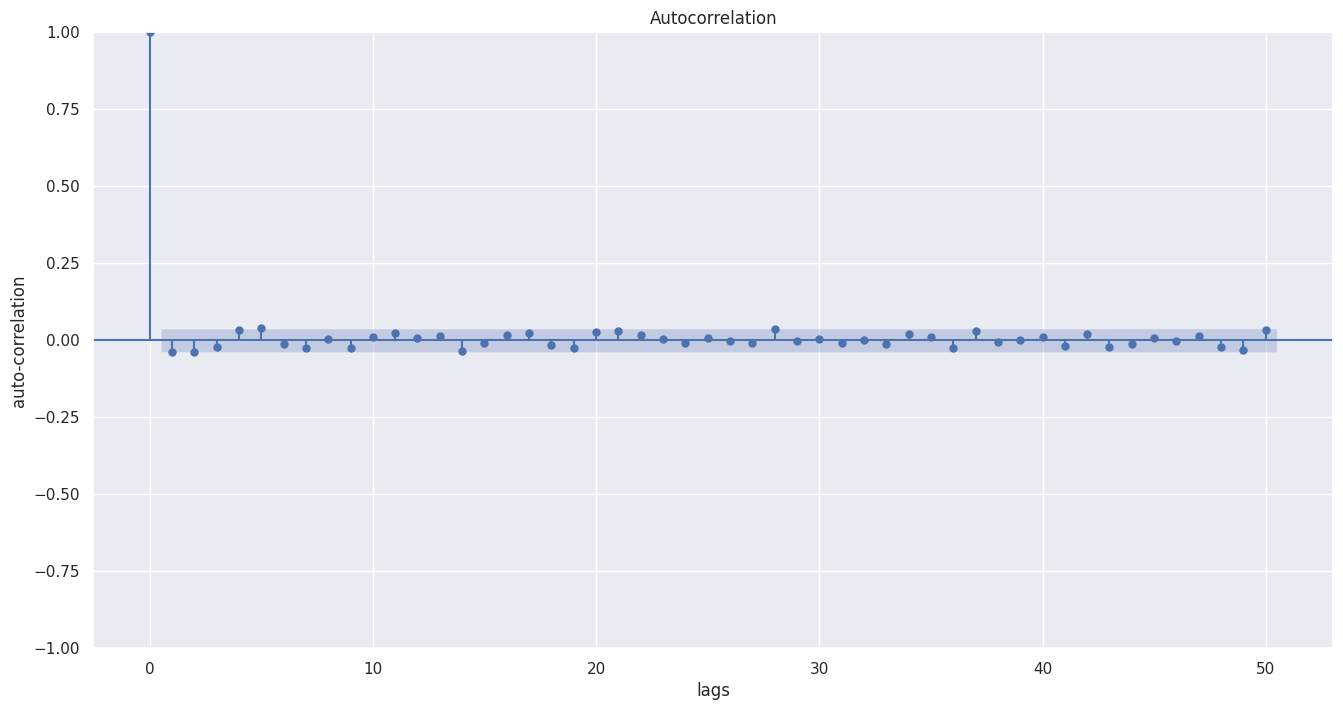

In [33]:
#draw autocorrelation for log return with 50 days time lag
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(16, 8))
acf = plot_acf(d1.log_rtn, lags=50, ax=ax)
ax.set_xlabel('lags')
ax.set_ylabel('auto-correlation');